<a href="https://colab.research.google.com/github/sayan0506/Face-Recognition-pipeline-using-SOTA-ArcFace/blob/main/Face_recognition_using_arcface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Face recognition Pipeline design using arcface**

This notebook is inspired from the paper [ArcFace: Additive Angular Margin Loss for Deep Face Recognition](https://arxiv.org/pdf/1801.07698v3.pdf)

Git repo: [Insightface_Pytorch](https://github.com/TreB1eN/InsightFace_Pytorch)

**Install Dependencies**

In [1]:
# install tensorboardX
!pip install tensorboardX

     |████████████████████████████████| 122kB 7.2MB/s 


## **Mount Drive**

Drive: [link](hazrasayan2021@gmail.com)

In [2]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## **Import Dependencies**

In [3]:
from pathlib import Path
import numpy as np
import cv2
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# data pipeline
# helps to create dict where, use keys as atribute
from easydict import EasyDict as edict

from torchvision import transforms as trans
from torchvision.datasets import ImageFolder
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader

# ensures loading truncated images 
ImageFile.LOAD_TRUNCATED_IMAGES = True

# model build
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, ReLU, Sigmoid, Dropout2d, Dropout, AvgPool2d, MaxPool2d, AdaptiveAvgPool2d, Sequential, Module, Parameter
import torch.nn.functional as F
import torch
from collections import namedtuple
import math
import pdb

# model training
from tensorboardX import SummaryWriter
from torch import optim
from gdrive.MyDrive.arcface import model
from tqdm import tqdm
from torch.nn import CrossEntropyLoss

## **Environment Setup**

**Check GPU utilization**

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {device}')

Running on device: cuda:0


In [5]:
print(f'Device info\n{torch.cuda.get_device_properties(0)}')

Device info
_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


## **Data Distribution**

## **Dataset Load**

Load the avengers face dataset
* Source: [Kaggle](https://www.kaggle.com/rawatjitesh/avengers-face-recognition)
* Drive link: [Dataset](https://drive.google.com/drive/folders/1VYuEXVOzUtd7fOaaLv7oW4YwGYbvh80w?usp=sharing)

**Defining Configuration Dictionary, which will contain the important metadata regarding the ML pipeline**

In [6]:
# config edict dictionary initialize
config = edict()

In [7]:
# configure device
config.device = device

In [8]:
# avengers face dataset path
dataset_path = "/content/gdrive/MyDrive/Kaggle Avengers face dataset/Marvels_face_dataset"
# add dataset path to config
config.imgs_folder = dataset_path

#### **Data Analysis**

In [9]:
# identity list
identity_list = ['chris_evans', 'chris_hemsworth', 'mark_ruffalo', 'robert_downey_jr', 'scarlett_johansson']
# identity path
identity_path = [os.path.join(config.imgs_folder, identity) for identity in identity_list]

print(f'Identity Paths\n{identity_path}')

Identity Paths
['/content/gdrive/MyDrive/Kaggle Avengers face dataset/Marvels_face_dataset/chris_evans', '/content/gdrive/MyDrive/Kaggle Avengers face dataset/Marvels_face_dataset/chris_hemsworth', '/content/gdrive/MyDrive/Kaggle Avengers face dataset/Marvels_face_dataset/mark_ruffalo', '/content/gdrive/MyDrive/Kaggle Avengers face dataset/Marvels_face_dataset/robert_downey_jr', '/content/gdrive/MyDrive/Kaggle Avengers face dataset/Marvels_face_dataset/scarlett_johansson']


**Define image and label dataframe for analysis**

In [10]:
# image dataframe
img_df = pd.DataFrame(columns = ['Image', 'Label'])

# label dataframe
label_df = pd.DataFrame(columns = identity_list)

**Fetching info**

In [13]:

print('\n[INFO] Loading images ...')
# total sample count
sample_count = 0
for sr, id_path in enumerate(identity_path):
  print(f'[INFO] Processing {identity_list[sr]}')
  sample_list = os.listdir(id_path)

  for id_sample in sample_list:
    # removing the .DS_store files from list, which contains the folder infos
    if id_sample == '.DS_store':
      sample_list.remove(id_sample)
  # categorical count
  count = 0
  for id_sample in sample_list:
    id_sample_path = os.path.join(id_path, id_sample)
    if id_sample_path.endswith(".jpg") == True or id_sample_path.endswith(".JPG") == True or id_sample_path.endswith(".png") == True or id_sample_path.endswith(".PNG") == True:
      img_df.loc[sample_count,'Image'], img_df.loc[sample_count,'Label'] = id_sample, identity_list[sr]
      #self.img_df.loc[sample_count,'Shape'] = img.shape
      count += 1
      sample_count += 1

  label_df.loc[0, identity_list[sr]] = count
  print(count)
  # checks whether all the samples are loaded successfully or not to img_df
  assert len(sample_list) == count

print(f'Data distribution of different identities\n{label_df}')
print(f'Image dataframe\n{img_df}')


[INFO] Loading images ...
[INFO] Processing chris_evans
50
[INFO] Processing chris_hemsworth
53
[INFO] Processing mark_ruffalo
66
[INFO] Processing robert_downey_jr
51
[INFO] Processing scarlett_johansson
54
Data distribution of different identities
  chris_evans chris_hemsworth mark_ruffalo robert_downey_jr scarlett_johansson
0          50              53           66               51                 54
Image dataframe
                        Image               Label
0           chris_evans34.png         chris_evans
1           chris_evans32.png         chris_evans
2            chris_evans6.png         chris_evans
3           chris_evans47.png         chris_evans
4           chris_evans13.png         chris_evans
..                        ...                 ...
269  scarlett_johansson54.png  scarlett_johansson
270  scarlett_johansson52.png  scarlett_johansson
271   scarlett_johansson9.png  scarlett_johansson
272  scarlett_johansson53.png  scarlett_johansson
273   scarlett_johansson5

**Target Distribution Visualize**

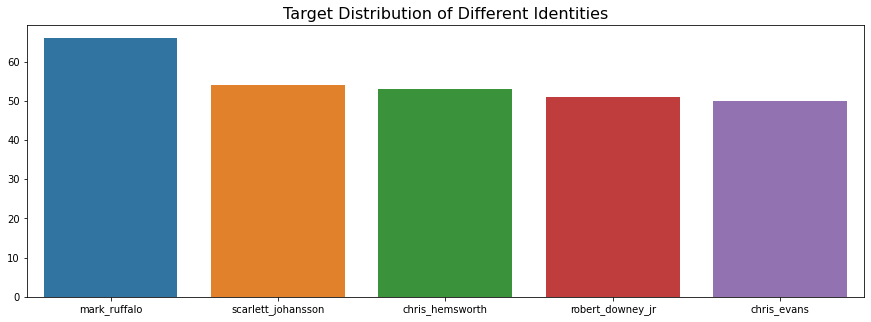

In [14]:
def distribution_vis(counts_series, label):
  '''
  Target distribution
  '''
  fig = plt.figure(figsize = (15,5))
  sns.barplot(x = counts_series.index, y = counts_series.values)
  plt.title(label, fontsize = 16)

# returns pandas series with classes as keys and count as values
target_counts = img_df['Label'].value_counts()

# vis distribution
distribution_vis(target_counts, label = 'Target Distribution of Different Identities')

#### **Train-Validation-Test Split**

We are taking train, valid, test ratio as - [0.9:0.05:0.05]

In [38]:
# validation split
val_ratio = 0.10
# test split
test_ratio = 0.5

# image_ids
img_ids = img_df.loc[:,'Image']

# image_ids
label_ids = img_df.loc[:,'Label']

**Defining train, validation, test dataframe**

In [39]:
# train df
train_df = pd.DataFrame(columns=['Image','Label'])
# validation main df
valid_main_df = pd.DataFrame(columns=['Image','Label'])
# validation df
valid_df = pd.DataFrame(columns=['Image','Label'])
# test df
test_df = pd.DataFrame(columns=['Image','Label'])

**Train-Valid_main Split**

In [40]:
train_df['Image'], valid_main_df['Image'], train_df['Label'], valid_main_df['Label'] = train_test_split(img_ids, label_ids,
                                                                                                      test_size = val_ratio,
                                                                                                      random_state = 28,
                                                                                                      stratify = label_ids,
                                                                                                      shuffle = True
                                                                                                      )

**Validation-Test Split**

In [41]:
valid_df['Image'], test_df['Image'], valid_df['Label'], test_df['Label'] = train_test_split(valid_main_df['Image'], valid_main_df['Label'],
                                                                                                      test_size = test_ratio,
                                                                                                      random_state = 28,
                                                                                                      stratify = valid_main_df['Label'],
                                                                                                      shuffle = True
                                                                                                      )

In [42]:
print(f'Train dataframe shape {train_df.shape}')
print(f'Validation dataframe shape {valid_df.shape}')
print(f'Test dataframe shape {test_df.shape}')

Train dataframe shape (246, 2)
Validation dataframe shape (14, 2)
Test dataframe shape (14, 2)


**STratification Check**

In [60]:
def distribution_vis_check(train, valid, test):
  '''
  Target distribution
  '''
  xdf = [train.index, valid.index, test.index]
  ydf = [train.values, valid.values, test.values]
  label = ['Train Distribution', 'Validation Distribution', 'Test Distribution'] 
  fig = plt.figure(figsize = (20,5))
  for i in range(len(xdf)):
    fig.add_subplot(1, len(xdf), i+1)
    sns.barplot(x = xdf[i], y = ydf[i])
    plt.xlabel(label[i], fontsize = 16)


**Startifiction check using the df**

In [62]:
print(train_df['Label'].value_counts())
print(valid_df['Label'].value_counts())
print(test_df['Label'].value_counts())

mark_ruffalo          59
scarlett_johansson    48
chris_hemsworth       48
robert_downey_jr      46
chris_evans           45
Name: Label, dtype: int64
mark_ruffalo          4
scarlett_johansson    3
chris_evans           3
robert_downey_jr      2
chris_hemsworth       2
Name: Label, dtype: int64
chris_hemsworth       3
scarlett_johansson    3
mark_ruffalo          3
robert_downey_jr      3
chris_evans           2
Name: Label, dtype: int64


**Startification CHek Visualize**

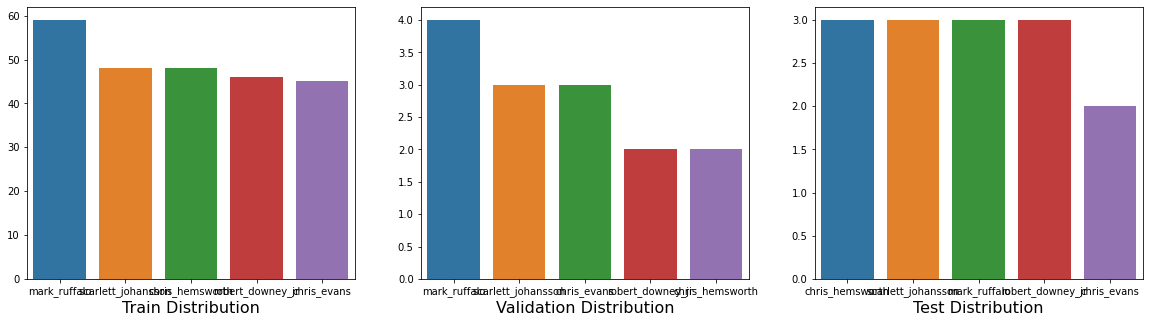

In [61]:
distribution_vis_check(train_df['Label'].value_counts(), valid_df['Label'].value_counts(), test_df['Label'].value_counts())

**From all the above analysis, the data train-valid-test spli is stratified**

## **Create Torch Dataset**

**Configure input image size**

In [12]:
config.input_size = (112,112)

**Create train dataset from the folder**

In [13]:
def get_train_dataset(config):
  # create torchvision transforms object for train data
  train_transform = trans.Compose([
                                   trans.RandomHorizontalFlip(), # random horizonttal flip of faces
                                   trans.ToTensor(), # convert img to torch tensor
                                   trans.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]), # normalize
                                   trans.Resize(config.input_size, interpolation=trans.InterpolationMode.BICUBIC)
  ])
  
  # fetch and transform the images using torchvision transforms to create dataset
  # from the image folder
  ds = ImageFolder(config.imgs_folder, train_transform)
  class_num = ds[-1][1] + 1 # total class is the index of last folder + 1
  return ds, class_num

# create train dataset
train_ds, train_class_num = get_train_dataset(config)

In [14]:
print(f'Train Dataset info {train_ds},\ncontains {train_class_num} different identities!')
print(f'Classes available in the dataset \n{train_ds.classes},\nhaving class ids {set(train_ds.targets)} respectively!')

Train Dataset info Dataset ImageFolder
    Number of datapoints: 274
    Root location: /content/gdrive/MyDrive/Kaggle Avengers face dataset/Marvels_face_dataset
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
               Resize(size=[112, 112], interpolation=bicubic)
           ),
contains 5 different identities!
Classes available in the dataset 
['chris_evans', 'chris_hemsworth', 'mark_ruffalo', 'robert_downey_jr', 'scarlett_johansson'],
having class ids {0, 1, 2, 3, 4} respectively!


#### **Define Pytorch DataLoader**

Define the train_loader function, where we can pass dataset mode(as 'vgg' or 'ms1m') through configuration dictionary.


In [15]:
# define the train_loader function, where we can pass dataset mode(as 'vgg' or 'ms1m') through configuration dictionary
def get_train_loader(ds, class_num, config):
  if config.data_mode in ['ms1m','vgg']:
    # create train_loader, by deafult shuffles the datapoints
    train_loader = DataLoader(ds, batch_size=config.batch_size, shuffle = True, pin_memory = config.pin_memory,
                              num_workers = config.num_workers)
    return train_loader, train_class_num

**Defining metadata parameters to config**

In [16]:
# initializing data_mode as 'ms1m' dataset
config.data_mode = 'ms1m'
# initializing batch_size to 64
config.batch_size = 64
# pin_memory status is set to True, which enables to load samples of data to device(GPU), spped-up the training
config.pin_memory = True
# initializing the number of workers to 4
config.num_workers = 4

**Create the train dataloader**

In [17]:
train_loader, _ = get_train_loader(train_ds, train_class_num, config)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## **ArcFace Model Build**

There are Backbone, Mobilefacenet models for generating face embedding. But, We are considering to use only Mobilefacenet, as it's a light-weight model.

**Define Flatten Block**

In [18]:
# flatten block
class Flatten(Module):
  def forward(self, input):
    return input.view(input.size(0), -1)

**Define L2_norm block**

In [19]:
def l2_norm(input, axis = 1):
  norm = torch.norm(input, 2, axis, True)
  output = torch.div(input, norm)
  return output

**Define a Convolution Block**

In [20]:
# defining torch deafult sub-class api
# PReLU - Parameterized ReLU used to handle the variations(parameterize activation @ x< 0) in lower level layers 
class Conv_block(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(Conv_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels=out_c, kernel_size=kernel, groups=groups, stride=stride, padding=padding, bias=False)
        self.bn = BatchNorm2d(out_c)
        self.prelu = PReLU(out_c)
    
    # forward prop
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.prelu(x)
        return x

**Define Linear Block**

In [21]:
class Linear_block(Module):
    def __init__(self, in_c, out_c, kernel=(1, 1), stride=(1, 1), padding=(0, 0), groups=1):
        super(Linear_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels=out_c, kernel_size=kernel, groups=groups, stride=stride, padding=padding, bias=False)
        self.bn = BatchNorm2d(out_c)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x

**Define Depthwise Seperable Convolution Block**

In [22]:
class Depth_Wise(Module):
     def __init__(self, in_c, out_c, residual = False, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=1):
        super(Depth_Wise, self).__init__()
        self.conv = Conv_block(in_c, out_c=groups, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.conv_dw = Conv_block(groups, groups, groups=groups, kernel=kernel, padding=padding, stride=stride)
        self.project = Linear_block(groups, out_c, kernel=(1, 1), padding=(0, 0), stride=(1, 1))
        self.residual = residual
     def forward(self, x):
        if self.residual:
            short_cut = x
        x = self.conv(x)
        x = self.conv_dw(x)
        x = self.project(x)
        if self.residual:
            output = short_cut + x
        else:
            output = x
        return output

**Define Residual Block**

In [56]:
class Residual(Module):
    def __init__(self, c, num_block, groups, kernel=(3, 3), stride=(1, 1), padding=(1, 1)):
        super(Residual, self).__init__()
        modules = []
        for _ in range(num_block):
            modules.append(Depth_Wise(c, c, residual=True, kernel=kernel, padding=padding, stride=stride, groups=groups))
        self.model = Sequential(*modules)
    def forward(self, x):
        return self.model(x)

**Define the embedding-size in the config**

In [57]:
config.embedding_size = 512

#### **Define Mobilefacenet Model**

In [58]:
class MobileFaceNet(Module):
    def __init__(self, embedding_size):
        super(MobileFaceNet, self).__init__()
        self.conv1 = Conv_block(3, 64, kernel=(3, 3), stride=(2, 2), padding=(1, 1))
        self.conv2_dw = Conv_block(64, 64, kernel=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
        self.conv_23 = Depth_Wise(64, 64, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=128)
        self.conv_3 = Residual(64, num_block=4, groups=128, kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_34 = Depth_Wise(64, 128, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=256)
        self.conv_4 = Residual(128, num_block=6, groups=256, kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_45 = Depth_Wise(128, 128, kernel=(3, 3), stride=(2, 2), padding=(1, 1), groups=512)
        self.conv_5 = Residual(128, num_block=2, groups=256, kernel=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv_6_sep = Conv_block(128, 512, kernel=(1, 1), stride=(1, 1), padding=(0, 0))
        self.conv_6_dw = Linear_block(512, 512, groups=512, kernel=(7,7), stride=(1, 1), padding=(0, 0))
        self.conv_6_flatten = Flatten()
        self.linear = Linear(512, embedding_size, bias=False)
        self.bn = BatchNorm1d(embedding_size)
    
    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2_dw(out)

        out = self.conv_23(out)

        out = self.conv_3(out)
        
        out = self.conv_34(out)

        out = self.conv_4(out)

        out = self.conv_45(out)

        out = self.conv_5(out)

        out = self.conv_6_sep(out)

        out = self.conv_6_dw(out)

        out = self.conv_6_flatten(out)

        out = self.linear(out)

        out = self.bn(out)
        return l2_norm(out)

**Initialize the Mobilefacenet model**

In [59]:
# call model object
mobilefacenet_model = model.MobileFaceNet(embedding_size= config.embedding_size).to(config.device)

#print(f'Model summary:\n{mobilefacenet_model}')

#### **Define Arcface Head**

Implementation of **additive margin softmax** loss in https://arxiv.org/abs/1801.05599

In [60]:
class Arcface(Module):
    # implementation of additive margin softmax loss in https://arxiv.org/abs/1801.05599
    # total class is set to deafult as the original dataset    
    def __init__(self, embedding_size=512, classnum=51332,  s=64., m=0.5):
        super(Arcface, self).__init__()
        self.classnum = classnum
        self.kernel = Parameter(torch.Tensor(embedding_size,classnum))
        # initial kernel
        self.kernel.data.uniform_(-1, 1).renorm_(2,1,1e-5).mul_(1e5)
        self.m = m # the margin value, default is 0.5
        self.s = s # scalar value default is 64, see normface https://arxiv.org/abs/1704.06369
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.mm = self.sin_m * m  # issue 1
        self.threshold = math.cos(math.pi - m)
    def forward(self, embbedings, label):
        # weights norm
        nB = len(embbedings)
        kernel_norm = l2_norm(self.kernel,axis=0)
        # cos(theta+m)
        cos_theta = torch.mm(embbedings,kernel_norm)
#         output = torch.mm(embbedings,kernel_norm)
        cos_theta = cos_theta.clamp(-1,1) # for numerical stability
        cos_theta_2 = torch.pow(cos_theta, 2)
        sin_theta_2 = 1 - cos_theta_2
        sin_theta = torch.sqrt(sin_theta_2)
        cos_theta_m = (cos_theta * self.cos_m - sin_theta * self.sin_m)
        # this condition controls the theta+m should in range [0, pi]
        #      0<=theta+m<=pi
        #     -m<=theta<=pi-m
        cond_v = cos_theta - self.threshold
        cond_mask = cond_v <= 0
        keep_val = (cos_theta - self.mm) # when theta not in [0,pi], use cosface instead
        cos_theta_m[cond_mask] = keep_val[cond_mask]
        output = cos_theta * 1.0 # a little bit hacky way to prevent in_place operation on cos_theta
        idx_ = torch.arange(0, nB, dtype=torch.long)
        output[idx_, label] = cos_theta_m[idx_, label]
        output *= self.s # scale up in order to make softmax work, first introduced in normface
        return output

## **Model Training**

**Define to read bin of parameters**

In [61]:
def seperate_bn_paras(modules):
  # if modules is not object or instantiated
  if not isinstance(modules, list):
    modules = [*modules.modules()]
  paras_only_bn = []
  paras_wo_bn = []
  for layer in modules:
    if 'model' in str(layer.__class__):
      continue
    if 'container' in str(layer.__class__):
      continue
    else:
      if 'batchnorm' in str(layer.__class__):
        # takes bin of parameters
        paras_only_bn.extend([*layer.parameters()])
      else:
        paras_wo_bn.extend([*layer.parameters()])
  return paras_only_bn, paras_wo_bn


**Initialize training and define training parameters**

In [62]:
class face_learner(object):
  def __init__(self, config, model, train_loader, train_class_num, inference = False):
    print(f'Configureation-\n{config}')
    # if we want to load MobileFcaenet model
    if config.use_mobilefacenet:
      # model already loaded to device
      self.model = model
      print('MobilefaceNet model generated!')
    else:
      print('Load the different model!')
    
    # defines the milestones where, the lr_scheduler will act
    self.milestones = config.milestones
    self.loader, self.class_num = train_loader, train_class_num

    # helps to log summary of training using TensorboardX
    #self.writer = SummaryWriter(config.log_path)
    self.step = 0
    self.head = Arcface(embedding_size=config.embedding_size, classnum=self.class_num).to(device)

    print('Two model heads generated!')

    paras_only_bn, paras_wo_bn = seperate_bn_paras(self.model)   
    print(len(paras_only_bn))
    print(len(paras_wo_bn))
    # define optimizer for mobilefacenet
    if config.use_mobilefacenet:
      self.optimizer = optim.SGD([
                                  {'params': paras_wo_bn[:-1], 'weight_decay': 4e-05},# weight decay for the params
                                  {'params': [paras_wo_bn[-1]] + [self.head.kernel], 'weight_decay': 4e-04},
                                  {'params': paras_only_bn}
      ], lr = config.lr, momentum = config.momentum)
    
    else:
      self.optimizer = optim.SGD([
                                  {'params': paras_wo_bn + [self.head.kernel], 'weight_decay': 5e-04},
                                  {'params': paras_only_bn}
      ], lr = config.lr, momentum = config.momentum)
  
    print(self.optimizer)
    
    print('Optimizers generated')
    # log loss to every (len of loader//100) step
    self.board_loss_every = len(self.loader)//100
    # evaluate every (len of loader//10) step
    self.evaluate_every = len(self.loader)//10
    # save after (len(loader)//5) step
    self.save_every = len(self.loader)//5
    
  # lr scheduler
  def schedule_lr(self):
    for params in self.optimizer.param_groups:
      params['lr']/=10
    print(self.optimizer)


**Configure metadata for training**

In [63]:
# define work_space 
config.work_path = Path('work_space/')

# create work_space path, if not existed
if not os.path.isdir(config.work_path):
  os.mkdir(config.work_path)

# configure logpath
config.log_path = config.work_path/'log'

# create log path, if not existed
#if not os.path.isdir(config.work_path/'log'):
#  os.mkdir(config.work_path/'log')

# configure mobilefacenet status
config.use_mobilefacenet = True

# configure milestones
config.milestones = [12,15,18]

# configure momentum
config.momentum = 0.9

# configure learning rate
config.lr = 1e-03

# loss fn
config.ce_loss = CrossEntropyLoss()

#### **Define Model Train**

In [66]:
def train(config, epochs):
  learner = face_learner(config, mobilefacenet_model, train_loader, train_class_num)
  learner.model.train()
  running_loss = 0
  for e in range(epochs):
    print('epoch {} started'.format(e))
    # at each milestone learning rate is changes according to the scheduler
    if e == learner.milestones[0]:
        learner.schedule_lr()
    if e == learner.milestones[1]:
        learner.schedule_lr()      
    if e == learner.milestones[2]:
        learner.schedule_lr()                                 
    
    for imgs, labels in tqdm(iter(learner.loader)):
        imgs = imgs.to(config.device)
        labels = labels.to(config.device)
        learner.optimizer.zero_grad()
        embeddings = learner.model(imgs)
        thetas = learner.head(embeddings, labels)
        loss = config.ce_loss(thetas, labels)
        loss.backward()
        running_loss += loss.item()
        learner.optimizer.step()
        
        if learner.step % learner.board_loss_every == 0 and learner.step != 0:
            loss_board = running_loss / learner.board_loss_every
            learner.writer.add_scalar('train_loss', loss_board, self.step)
            running_loss = 0.
        
        '''
        if self.step % self.evaluate_every == 0 and self.step != 0:
            accuracy, best_threshold, roc_curve_tensor = self.evaluate(conf, self.agedb_30, self.agedb_30_issame)
            self.board_val('agedb_30', accuracy, best_threshold, roc_curve_tensor)
            accuracy, best_threshold, roc_curve_tensor = self.evaluate(conf, self.lfw, self.lfw_issame)
            self.board_val('lfw', accuracy, best_threshold, roc_curve_tensor)
            accuracy, best_threshold, roc_curve_tensor = self.evaluate(conf, self.cfp_fp, self.cfp_fp_issame)
            self.board_val('cfp_fp', accuracy, best_threshold, roc_curve_tensor)
            self.model.train()
        if self.step % self.save_every == 0 and self.step != 0:
            self.save_state(conf, accuracy)
        '''    
        learner.step += 1
        

In [67]:
train(config, epochs = 20)

Configureation-
{'device': device(type='cuda', index=0), 'imgs_folder': '/content/gdrive/MyDrive/Kaggle Avengers face dataset/Marvels_face_dataset', 'data_mode': 'ms1m', 'batch_size': 64, 'pin_memory': True, 'num_workers': 4, 'embedding_size': 512, 'work_path': PosixPath('work_space'), 'log_path': PosixPath('work_space/log'), 'use_mobilefacenet': True, 'milestones': [12, 15, 18], 'momentum': 0.9, 'lr': 0.001, 'ce_loss': CrossEntropyLoss(), 'input_size': [112, 112]}
MobilefaceNet model generated!
Two model heads generated!
100
83
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 4e-05

Parameter Group 1
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0004

Parameter Group 2
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Optimizers generated
epoch 0 started


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))

100%|██████████| 5/5 [00:02<00:00,  1.84it/s]

epoch 1 started




100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

epoch 2 started




100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

epoch 3 started




100%|██████████| 5/5 [00:02<00:00,  2.08it/s]

epoch 4 started




100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

epoch 5 started




100%|██████████| 5/5 [00:02<00:00,  2.00it/s]

epoch 6 started




100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

epoch 7 started




100%|██████████| 5/5 [00:02<00:00,  1.95it/s]

epoch 8 started




100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

epoch 9 started




100%|██████████| 5/5 [00:02<00:00,  1.94it/s]

epoch 10 started




100%|██████████| 5/5 [00:02<00:00,  1.95it/s]

epoch 11 started




100%|██████████| 5/5 [00:02<00:00,  1.99it/s]

epoch 12 started
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0001
    momentum: 0.9
    nesterov: False
    weight_decay: 4e-05

Parameter Group 1
    dampening: 0
    lr: 0.0001
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0004

Parameter Group 2
    dampening: 0
    lr: 0.0001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)




100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

epoch 13 started




100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

epoch 14 started




100%|██████████| 5/5 [00:02<00:00,  1.97it/s]

epoch 15 started
SGD (
Parameter Group 0
    dampening: 0
    lr: 1e-05
    momentum: 0.9
    nesterov: False
    weight_decay: 4e-05

Parameter Group 1
    dampening: 0
    lr: 1e-05
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0004

Parameter Group 2
    dampening: 0
    lr: 1e-05
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)




100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

epoch 16 started




100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

epoch 17 started




100%|██████████| 5/5 [00:02<00:00,  1.95it/s]

epoch 18 started
SGD (
Parameter Group 0
    dampening: 0
    lr: 1.0000000000000002e-06
    momentum: 0.9
    nesterov: False
    weight_decay: 4e-05

Parameter Group 1
    dampening: 0
    lr: 1.0000000000000002e-06
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0004

Parameter Group 2
    dampening: 0
    lr: 1.0000000000000002e-06
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)




100%|██████████| 5/5 [00:02<00:00,  1.90it/s]

epoch 19 started




100%|██████████| 5/5 [00:02<00:00,  1.95it/s]
